In [1]:
using Flux
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, @epochs
using Flux.Losses: logitcrossentropy
using MLDatasets
using Plots

## Get and prepare the data

We load the MNIST train and test data using MLDatasets:

In [2]:
# load full train set
train_x, train_y = MLDatasets.MNIST.traindata(Float32)

# load full test set
test_x, test_y = MLDatasets.MNIST.testdata(Float32)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [7, 2, 1, 0, 4, 1, 4, 9, 5, 9  …  7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

We check the shape of the MNIST data:

In [3]:
println("Size of train set: $(size(train_x))")
println("Size of test set: $(size(test_x))")

Size of train set: (28, 28, 60000)
Size of test set: (28, 28, 10000)


As we can see, the train dataset has 60000 examples and the test dataset has 10000. Each element of both datasets is a 28x28 matrix. Flux expects the data to be in a different shape . 
We need to transform the MNIST data so we can feed it into our Flux model. Thus, we flatten the input data, that is, we convert each 28x28 matrix into a 784-dimensional vector:

In [4]:
train_x = Flux.flatten(train_x)
test_x = Flux.flatten(test_x)

784×10000 Array{Float32,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  

https://chrisalbon.com/code/machine_learning/preprocessing_structured_data/one-hot_encode_nominal_categorical_features/

Now, we need to one-hot encode (see image above - Chris Albon) the labels so that our model can understand them:

In [5]:
# One-hot encode the labels
train_y, test_y = onehotbatch(train_y, 0:9), onehotbatch(test_y, 0:9)

(Bool[0 1 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 1; 0 0 … 0 0], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

Whenever we are working with a very large dataset, it is more convenient to work with mini batches of the data. We use Flux's [DataLoader](https://fluxml.ai/Flux.jl/stable/data/dataloader/) type so we can iterate over the mini batches of the data: 

In [6]:
# Create DataLoaders (mini-batch iterators)
train_data_loader = DataLoader((train_x, train_y), batchsize=256, shuffle=true)
test_data_loader = DataLoader((test_x, test_y), batchsize=256)

DataLoader{Tuple{Array{Float32,2},Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}}}((Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]), 256, 10000, true, 10000, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999, 10000], false)

## Model

As we mentioned above, our model has one input layer, one hidden layer (with 32 perceptrons), and an output layer (with num_classes perceptrons). 

In [7]:
# Construct model
img_size = (28,28,1)
num_classes = 10

model = Chain( Dense(prod(img_size), 32, relu),
                  Dense(32, num_classes))

ps = Flux.params(model) # model's trainable parameters

Params([Float32[-0.07582425 0.02542828 … -0.0016211248 -0.06204374; 0.0057818107 0.07168816 … 0.03780225 -0.040162228; … ; -0.026540529 0.07710746 … 0.06315562 0.015118687; 0.035058614 -0.012984065 … -0.054886896 -0.0048402925], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.09892084 -0.2296166 … 0.23926364 0.34173307; -0.029866401 -0.35210624 … 0.2280323 -0.13073415; … ; 0.16927409 0.36291304 … -0.16681334 0.012161752; -0.11990734 -0.30701593 … 0.3535769 0.27875617], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

We create a loss function and an accuracy function. It is very important to monitor loss during training time so we can decide when it's best to stop the training. 

In [8]:
function loss(data_loader, model)
    total_loss = 0.0f0
    num_elements = 0
    for (x, y) in data_loader
        ŷ = model(x)
        total_loss += logitcrossentropy(ŷ, y, agg=sum)
        num_elements +=  size(x)[end]
    end
    return total_loss / num_elements
end


function accuracy(data_loader, model)
    accuracy = 0
    num_elements = 0
    for (x, y) in data_loader
        ŷ = model(x)
        accuracy += sum(onecold(ŷ) .== onecold(y))
        num_elements += size(x)[end]
    end   
    
    return accuracy / num_elements
end


accuracy (generic function with 1 method)

We use the [Descent optimiser](https://fluxml.ai/Flux.jl/stable/training/optimisers/) (Gradient Descent) and set a value η for the learning rate:

In [9]:
η = 3e-4 

opt = Descent(η)

Descent(0.0003)

Finally, we can train our model. We train a neural network in stages (or epochs). In each epoch, we perform one step of the gradient descent algorithm and output the loss and accuracy.

In [10]:
epochs = 40

train_loss_results = []
test_loss_results = []
train_accuracy_results = []
test_accuracy_results = []

for epoch in 1:epochs
    for (x, y) in train_data_loader
        gs = gradient(() -> logitcrossentropy(model(x), y), ps) # Compute gradient
        Flux.Optimise.update!(opt, ps, gs) # Update parameters
     end
        
    # Compute accuracy and loss for all of the train and test data
    train_loss = loss(train_data_loader, model)
    train_acc = accuracy(train_data_loader, model)
    test_loss = loss(test_data_loader, model)
    test_acc = accuracy(test_data_loader, model)
    println("Epoch=$epoch")
    println("  train_loss = $train_loss, train_accuracy = $train_acc")
    println("  test_loss = $test_loss, test_accuracy = $test_acc")
    push!(train_loss_results, train_loss)
    push!(test_loss_results, test_loss)
    push!(train_accuracy_results, train_acc)
    push!(test_accuracy_results, test_acc)
end

Epoch=1
  train_loss = 2.2848907, train_accuracy = 0.11465
  test_loss = 2.280792, test_accuracy = 0.1162
Epoch=2
  train_loss = 2.2361443, train_accuracy = 0.13995
  test_loss = 2.2309375, test_accuracy = 0.1418
Epoch=3
  train_loss = 2.1969159, train_accuracy = 0.17005
  test_loss = 2.1906798, test_accuracy = 0.1722
Epoch=4
  train_loss = 2.1618845, train_accuracy = 0.1993
  test_loss = 2.1545837, test_accuracy = 0.2032
Epoch=5
  train_loss = 2.1286616, train_accuracy = 0.22865
  test_loss = 2.1203725, test_accuracy = 0.2326
Epoch=6
  train_loss = 2.0960646, train_accuracy = 0.25888333333333335
  test_loss = 2.0867333, test_accuracy = 0.2592
Epoch=7
  train_loss = 2.0636058, train_accuracy = 0.29101666666666665
  test_loss = 2.05321, test_accuracy = 0.2915
Epoch=8
  train_loss = 2.0309577, train_accuracy = 0.32438333333333336
  test_loss = 2.0194302, test_accuracy = 0.3269
Epoch=9
  train_loss = 1.9979835, train_accuracy = 0.35613333333333336
  test_loss = 1.9853249, test_accuracy = 

Plot train and test loss to check overfitting

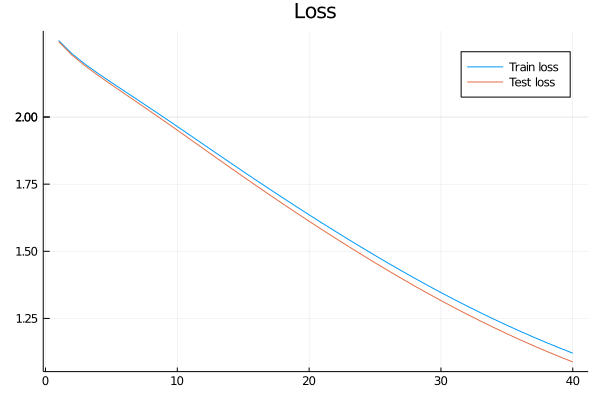

In [11]:
plot(1:length(train_loss_results), train_loss_results, title="Loss", label="Train loss")
plot!(1:length(test_loss_results), test_loss_results, label="Test loss")